<a href="https://colab.research.google.com/github/antoniodragoc/Projeto-de-Graduacao-Antonio-Drago-Caetano/blob/main/3_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception

from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

import pandas as pd

from fast_ml.model_development import train_valid_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [50]:
# Caminhos de treino e validaçção

# Obs - no diretório dados4 os dados estão separados em 75% treino 15% validação e 10% teste
path_train = 'D:/Users/N30090/OneDrive - ArcelorMittal/Pictures/Doutorado_img/dados_aimonino/train/'
path_val = 'D:/Users/N30090/OneDrive - ArcelorMittal/Pictures/Doutorado_img/dados_aimonino/val/'

batch_size = 20

In [51]:
# Gerando os dados a partir das imagens
train_datagen = ImageDataGenerator(    
    rotation_range = 90,
    vertical_flip = True,
    horizontal_flip = True,
    zoom_range=0.05,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'reflect',
    samplewise_center = True,
    samplewise_std_normalization = True
)

val_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )


test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )

In [52]:
# dados de treino
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size = (256, 256),
    batch_size= batch_size,
    shuffle=True,
    class_mode='categorical' 
)

Found 520 images belonging to 2 classes.


In [53]:
y_true = train_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
#dados de validação
val_generator = val_datagen.flow_from_directory(
    path_val,
    target_size = (256, 256),
    batch_size= batch_size,  
    shuffle=True,
    class_mode='categorical'     
)

Found 104 images belonging to 2 classes.


In [55]:
val_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
# Chamando a rede pré-treinada
conv_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(256,256,3))

first_freeze_layers = 20 #number of the first layers to freeze
for layer in conv_model.layers[0:first_freeze_layers]:
    layer.trainable = False

teste = keras.layers.Flatten()(conv_model.output)

# three hidden layers
teste = keras.layers.Dropout(0.4)(teste)
teste = keras.layers.Dense(128, activation='relu')(teste)
teste = keras.layers.Dense(64, activation='relu')(teste)

# final softmax layer with two categories
predictions = keras.layers.Dense(2, activation='softmax')(teste)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

full_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [57]:
#EARLY STOPPING ADICIONADO
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=40,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate = 0.01, 
    first_decay_steps = 500, 
    t_mul=2.4, 
    m_mul=1.3, 
    alpha=0.001, 
    name=None
)

In [58]:
# Compilando o modelo
full_model.compile(loss='categorical_crossentropy',
                  optimizer= keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=['accuracy','AUC'])

# Treinando o modelo com os dados de treino e teste
history = full_model.fit(
    train_generator,
    batch_size=len(train_generator),
    validation_data = val_generator,
    epochs = 100,
    callbacks=[callback]
)

Epoch 1/100
26/26 [==============================] - 87s 3s/step - loss: 2.8921 - accuracy: 0.5192 - auc: 0.5220 - val_loss: 0.6963 - val_accuracy: 0.5000 - val_auc: 0.5578
Epoch 2/100
26/26 [==============================] - 78s 3s/step - loss: 0.7315 - accuracy: 0.4750 - auc: 0.4664 - val_loss: 0.7451 - val_accuracy: 0.5000 - val_auc: 0.4432
Epoch 3/100
26/26 [==============================] - 78s 3s/step - loss: 0.7018 - accuracy: 0.4827 - auc: 0.4951 - val_loss: 0.7487 - val_accuracy: 0.5000 - val_auc: 0.4102
Epoch 4/100
26/26 [==============================] - 79s 3s/step - loss: 0.6981 - accuracy: 0.5077 - auc: 0.4956 - val_loss: 0.7020 - val_accuracy: 0.3750 - val_auc: 0.4465
Epoch 5/100
26/26 [==============================] - 79s 3s/step - loss: 0.6938 - accuracy: 0.5154 - auc: 0.5078 - val_loss: 0.7068 - val_accuracy: 0.5000 - val_auc: 0.4485
Epoch 6/100
26/26 [==============================] - 79s 3s/step - loss: 0.6964 - accuracy: 0.5019 - auc: 0.5204 - val_loss: 0.7066 - v

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


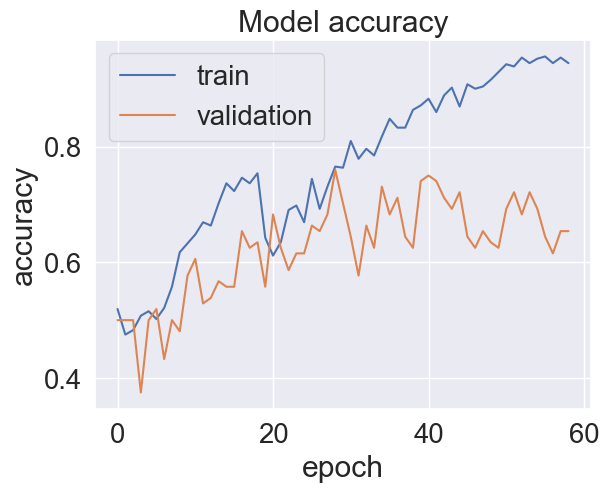

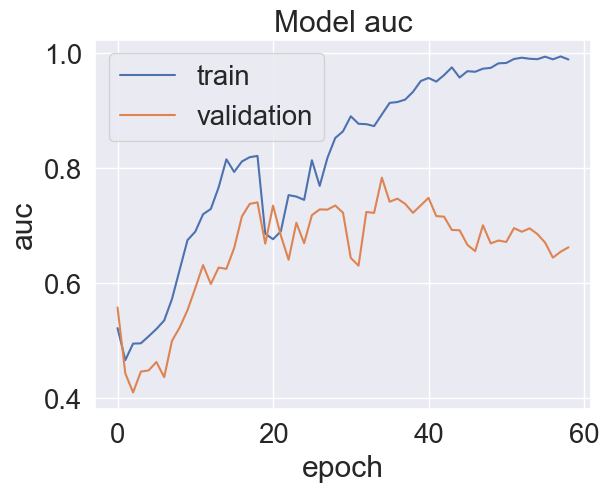

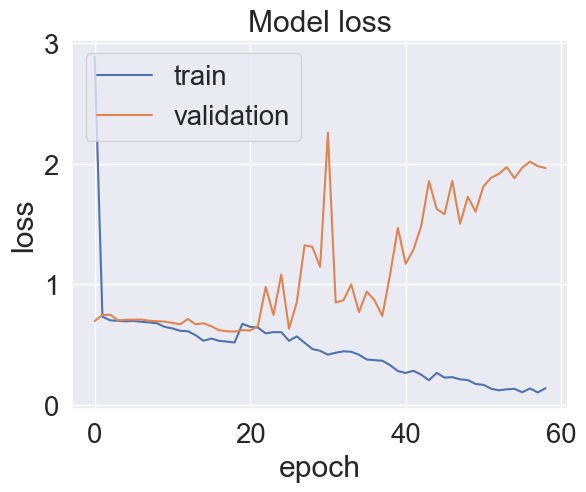

In [59]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
#dados de teste
path_test = 'D:/Users/N30090/OneDrive - ArcelorMittal/Pictures/Doutorado_img/dados_aimonino/test/'
test_generator =  test_datagen.flow_from_directory(
    path_test,
    target_size = (256, 256),
    shuffle = False,
    batch_size= batch_size,
    class_mode='categorical' 
    
    )

Found 68 images belonging to 2 classes.


In [61]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = full_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cmvgg = confusion_matrix(test_generator.classes, y_pred )

4/4 [==============================] - 4s 677ms/step


In [62]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68        34
           1       0.69      0.59      0.63        34

    accuracy                           0.66        68
   macro avg       0.67      0.66      0.66        68
weighted avg       0.67      0.66      0.66        68



In [63]:
class_names = ['Benign','Malignant']
report = classification_report(test_generator.classes, y_pred,target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose()
df_ = df[['precision', 'recall','f1-score']]
df_ = df_.loc[["Benign", "Malignant","macro avg"]]
df_.to_csv('dados_aimonino_resnet50.csv')
df_.head(10)


,precision,recall,f1-score
Benign,0.641026,0.735294,0.684932
Malignant,0.689655,0.588235,0.634921
macro avg,0.665340,0.661765,0.659926


Text(0.5, 10.124999999999995, 'Predicted label')

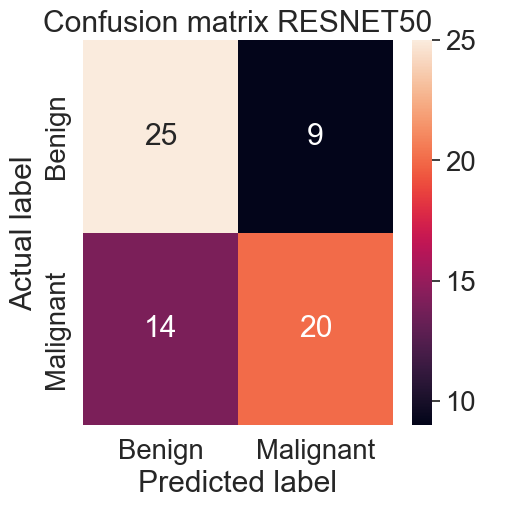

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_pred)
#cm = [[24,11],[1,34]]
plt.figure(figsize=(5,5))
x_axis_labels = ['Benign','Malignant'] # labels for x-axis
y_axis_labels = ['Benign','Malignant'] # labels for y-axis
ax = sns.heatmap(cm, annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sns.set(font_scale=1.8)
plt.title('Confusion matrix RESNET50')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')